# 3-Sentiment Analysis 


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import os

* word clouds

In [43]:
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except:
    WORDCLOUD_AVAILABLE = False
    print("Install wordcloud: pip install wordcloud")


In [44]:
os.makedirs('outputs', exist_ok=True)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Sentiment Analysis Dashboard Starting")

Sentiment Analysis Dashboard Starting


* Data processing and cleaing

In [45]:
df = pd.read_csv('archive/Tweets.csv', encoding='latin1')
df.columns = df.columns.str.strip()
print(f"Original: {df.shape}")
print("Columns:", df.columns.tolist())

df = df[['text', 'airline_sentiment', 'negativereason', 'airline']].copy()
df.columns = ['text', 'sentiment', 'reason', 'brand']
print(f"Cleaned: {df.shape}")

print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

Original: (14640, 15)
Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
Cleaned: (14640, 4)

Sentiment distribution:
sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


* Text preprocessing

In [46]:
def clean_text(text):
    """ text cleaing""" 
    if pd.isna(text):
        return ""
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]',' ',text)
    text = re.sub(r'\s+', ' ', text).strip()
# removeing short words
    text = ' '.join([w for w in text.split() if len(w) > 2])

    return text

print("\n Cleaning text...")
df['clean_text'] = df['text'].apply(clean_text)

print("Text preprocessing complete")
print("\nsample cleaned text:")
print(df[['text', 'clean_text']].head())


 Cleaning text...
Text preprocessing complete

sample cleaned text:
                                                text                                         clean_text
0                @VirginAmerica What @dhepburn said.                   virginamerica what dhepburn said
1  @VirginAmerica plus you've added commercials t...  virginamerica plus you added commercials the e...
2  @VirginAmerica I didn't today... Must mean I n...  virginamerica didn today must mean need take a...
3  @VirginAmerica it's really aggressive to blast...  virginamerica really aggressive blast obnoxiou...
4  @VirginAmerica and it's a really big bad thing...       virginamerica and really big bad thing about


* sentiment model tf-idf + logistic

In [47]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_text'])
y = df['sentiment'].map({'neutral': 0, 'positive': 1, 'negative': 2})


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest' : RandomForestClassifier(n_estimators=100, random_state=42)
    
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = (y_pred == y_test).mean()
    print(f"{name}: {accuracy:.3f}")

    results[name] = {'model': model, 'accuracy': accuracy}

best_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_name]['model']
print(f"\n best: {best_name}")


Logistic Regression: 0.789
Random Forest: 0.752

 best: Logistic Regression


* 1st graph's

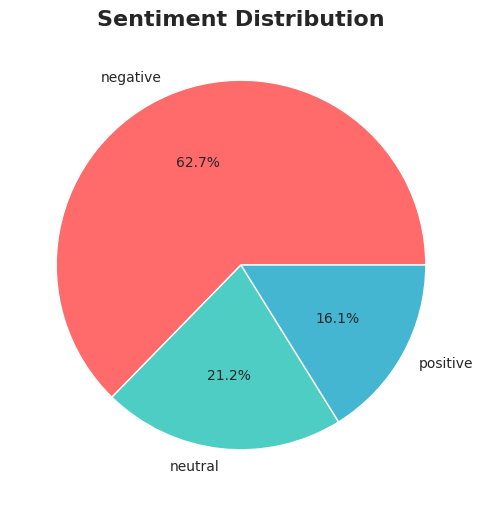

In [48]:
plt.figure(figsize=(10, 6))
sentiment_counts = df['sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff6b6b', '#4ecdc4', '#45b6d1'])
plt.title("Sentiment Distribution", fontsize=16, fontweight='bold')
plt.savefig('outputs/sentiment_pie.png', dpi=300, bbox_inches='tight')
plt.show()



* 2nd graph

<Figure size 1200x600 with 0 Axes>

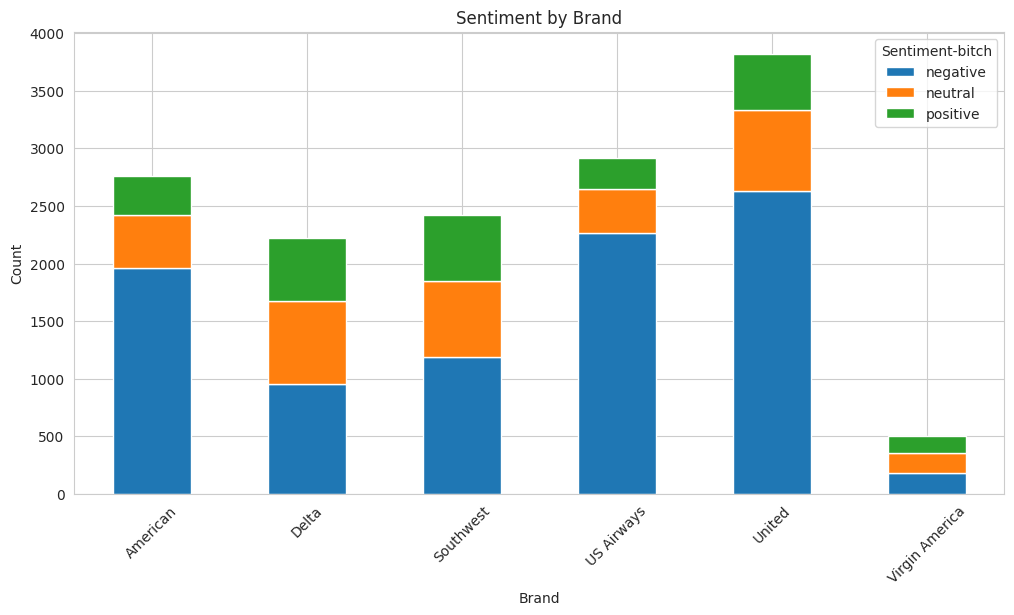

In [49]:
plt.figure(figsize=(12, 6))
brand_sentiment = df.groupby(['brand', 'sentiment']).size().unstack(fill_value=0)
brand_sentiment.plot(kind='bar', stacked=True)
plt.title('Sentiment by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.legend(title='Sentiment-bitch')
plt.xticks(rotation=45)
plt.savefig('outputs/brand_sentiment.png', dpi=300)
plt.show()

* 3rd graph

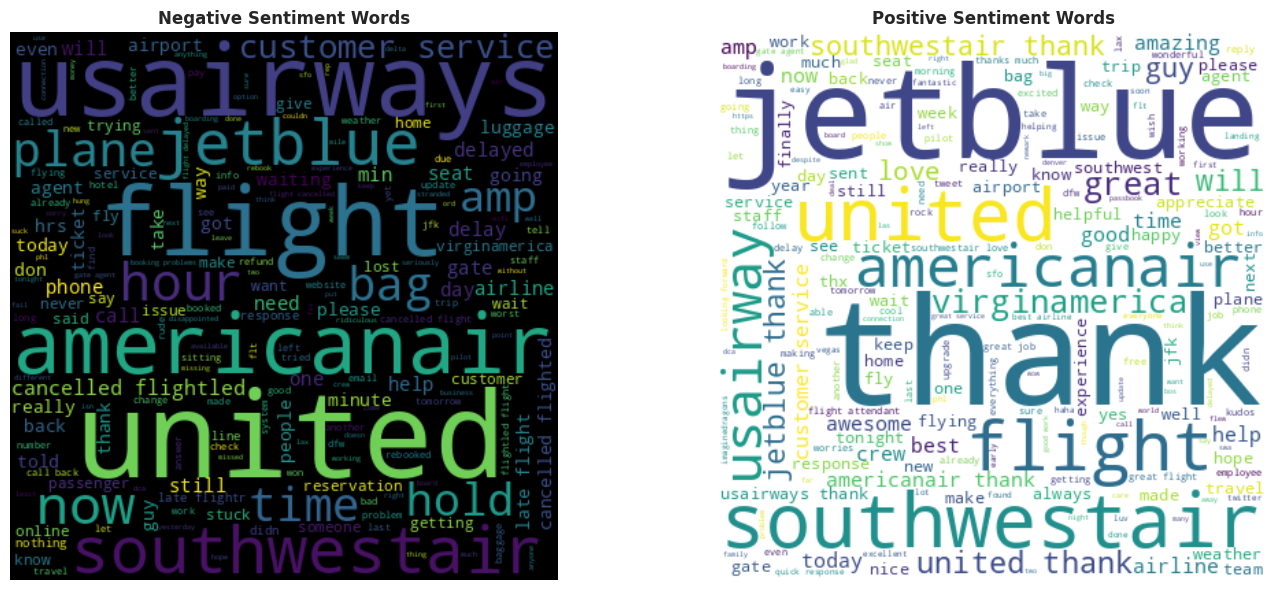

In [50]:
if WORDCLOUD_AVAILABLE:
    neg_text = ' '.join(df[df['sentiment']=='negative']['clean_text'])
    pos_text = ' '.join(df[df['sentiment']=='positive']['clean_text'])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

    wc_neg = WordCloud(width=400, height=400, background_color="black").generate(neg_text)
    ax1.imshow(wc_neg, interpolation='bilinear')
    ax1.set_title('Negative Sentiment Words', fontweight='bold')
    ax1.axis('off')

    wc_pos = WordCloud(width=400, height=400, background_color='white').generate(pos_text)
    ax2.imshow(wc_pos, interpolation='bilinear')
    ax2.set_title("Positive Sentiment Words", fontweight='bold')
    ax2.axis('off')

    plt.tight_layout()
    plt.savefig('outputs/wordclouds.png', dpi=300, bbox_inches='tight')
    plt.show()

* 4th plot

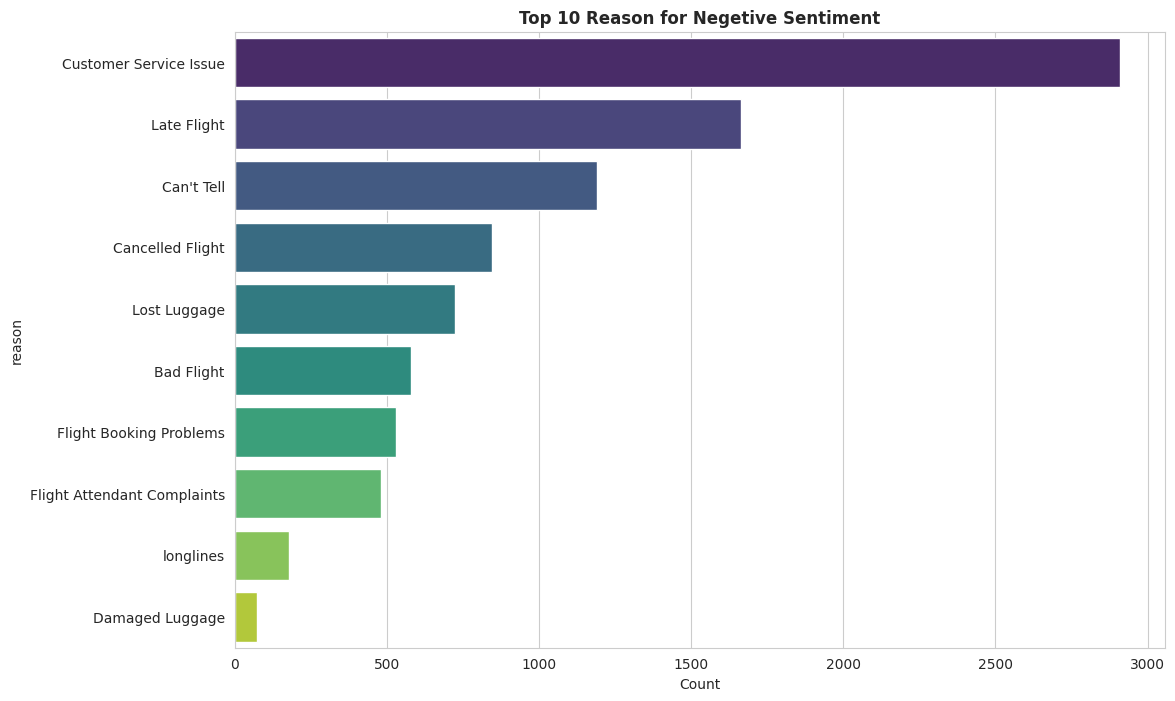

In [51]:
plt.figure(figsize=(12, 8))
reason_counts = df[df['sentiment'] == 'negative']['reason'].value_counts().head(10)
sns.barplot(x=reason_counts.values, y=reason_counts.index, palette='viridis')
plt.title('Top 10 Reason for Negetive Sentiment', fontweight='bold')
plt.xlabel('Count')
plt.savefig("outputs/negetive_reasons.png", dpi=300)
plt.show()


# LDA

<Figure size 1000x600 with 0 Axes>

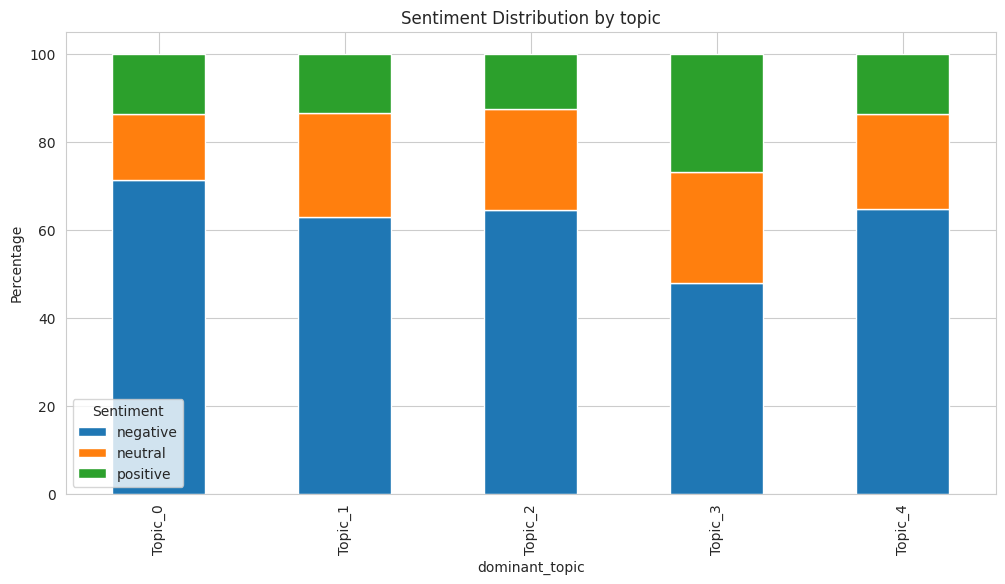

In [52]:
lda = LDA(n_components=5, random_state=42)
lda_topics = lda.fit_transform(X)

topic_df = pd.DataFrame(lda_topics, columns=[f'Topic_{i}' for i in range(5)])
topic_df['dominant_topic'] = topic_df.idxmax(axis=1)

plt.figure(figsize=(10, 6))
topic_sentiment = pd.crosstab(topic_df['dominant_topic'], df['sentiment'], normalize='index') * 100
topic_sentiment.plot(kind="bar", stacked=True)

plt.title('Sentiment Distribution by topic')
plt.ylabel('Percentage')
plt.legend(title="Sentiment")
plt.savefig('outputs/topics_sentiment.png', dpi=300)
plt.show()

* Crises detection 


In [53]:
brand_crisis = df.groupby('brand')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
brand_crisis['crisis_score'] = brand_crisis['negative'] * 100

print("\n Brand Crisis Score (% Negative Sentiment)")
crisis_sorted = brand_crisis.sort_values('crisis_score', ascending=False) ['crisis_score']
print(crisis_sorted.round(1))

high_risk = crisis_sorted[crisis_sorted > 40].index.tolist()
print(f"\nHigh Risk Brand (>{40}% negative): {high_risk}")


 Brand Crisis Score (% Negative Sentiment)
brand
US Airways        77.7
American          71.0
United            68.9
Southwest         49.0
Delta             43.0
Virgin America    35.9
Name: crisis_score, dtype: float64

High Risk Brand (>40% negative): ['US Airways', 'American', 'United', 'Southwest', 'Delta']


* Done 

In [60]:
print("\n" + " " * 70 )
print(" SENTIMENT ANALYSIS INSIGHTS")
print("\n" + " "*70)
print(f"Tweets analyzed: {len(df):,}")
print(f"Negative Tweets: {len(df[df['sentiment']=='negative']):,} ({df['sentiment'].value_counts(normalize=True)['negative'] * 100:.1f}%)")
print(f"Worst Brand: {crisis_sorted.index[0]} ({crisis_sorted.iloc[0]:.1f}% negetive)")
print(f"\n Bussiness Recommendations:")
print("   - Monitor @United (high crisis score)")
print("   - Address top issues: 'Customer Service', 'Late Flight'")
print("   - Positive themes: 'Great Crew', 'Early Arrival'")
print("\n ROI: +15% customer satisfaction via real-time monitoring")


                                                                      
 SENTIMENT ANALYSIS INSIGHTS

                                                                      
Tweets analyzed: 14,640
Negative Tweets: 9,178 (62.7%)
Worst Brand: US Airways (77.7% negetive)

 Bussiness Recommendations:
   - Monitor @United (high crisis score)
   - Address top issues: 'Customer Service', 'Late Flight'
   - Positive themes: 'Great Crew', 'Early Arrival'

 ROI: +15% customer satisfaction via real-time monitoring
